In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score
from sklearn.utils import resample
#from sklearn.linear_model import SGDClassifier , LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from helper import get_confusion_matrix, model_results

plt.style.use('ggplot')

pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv("train_sampled.csv", index_col=0)

## Preparing the data for Bagging & Boosting

In [3]:
le =LabelEncoder()
serviceType =le.fit_transform(train_data['ServiceType'])

train_nonlinear= train_data.copy()
train_nonlinear['ServiceType'] = serviceType

features = train_nonlinear.drop(['Provider', 'PotentialFraud', 'INDEX'], axis=1)
target= train_nonlinear['PotentialFraud']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [6]:
adaBoost = AdaBoostClassifier()

grid_param = ({
    "n_estimators": [80,100,115,125,150],
     "learning_rate": np.linspace(start=0.1, stop=2, num=10, dtype=float)}
)

ada_search = GridSearchCV(adaBoost, grid_param, scoring='accuracy', cv=5, return_train_score=True)
ada_search = ada_search.fit(X_train, y_train)

In [8]:
print(ada_search.best_params_)
print(ada_search.best_score_)

{'learning_rate': 1.3666666666666667, 'n_estimators': 150}
0.9181754779099836


Text(0, 0.5, 'Features')

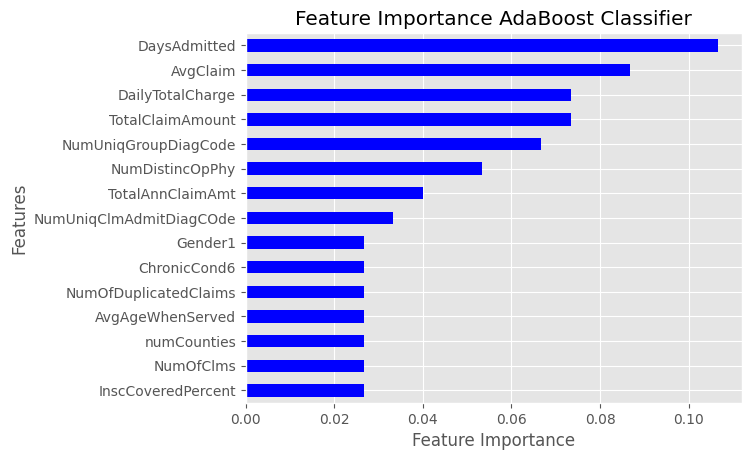

In [9]:
#Feature importance
sorted_importance = sorted(zip(features.columns, ada_search.best_estimator_.feature_importances_), key=lambda t:t[1], reverse=True)[:15]
sorted_importance.sort(key= lambda t : t[1])

a, b = zip(*sorted_importance) # this splits the list of tuples into two lists

pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.barh(x='feature_name',
                                                                 y='importance_score', 
                                                                 color='blue',
                                                                 legend=None)
plt.title('Feature Importance AdaBoost Classifier')
plt.xlabel("Feature Importance")
plt.ylabel("Features")

In [10]:
model_results(X_train, y_train, X_test, y_test, ada_search, show=True)

The Model Results for  GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': array([0.1       , 0.31111111, 0.52222222, 0.73333333, 0.94444444,
       1.15555556, 1.36666667, 1.57777778, 1.78888889, 2.        ]),
                         'n_estimators': [80, 100, 115, 125, 150]},
             return_train_score=True, scoring='accuracy')
************************************************************
Train Accuracy is equal to 0.936
Test Accuracy is equal to 0.924
The Precision score is 0.906
The Average Precision score is 0.884
The Recall score is 0.945
The F1 score is 0.925
The AUC/ROC score is 0.924
True-Positive: 927.000
True-Negative: 885.000
False-Positive: 96.000
False-Negative: 54.000
Correctly Classified: 1812.000
Incorrectly Classified: 150.000


[0.9360183533010451, 0.9235474006116208, 0.906158357771261, 0.944954128440367]

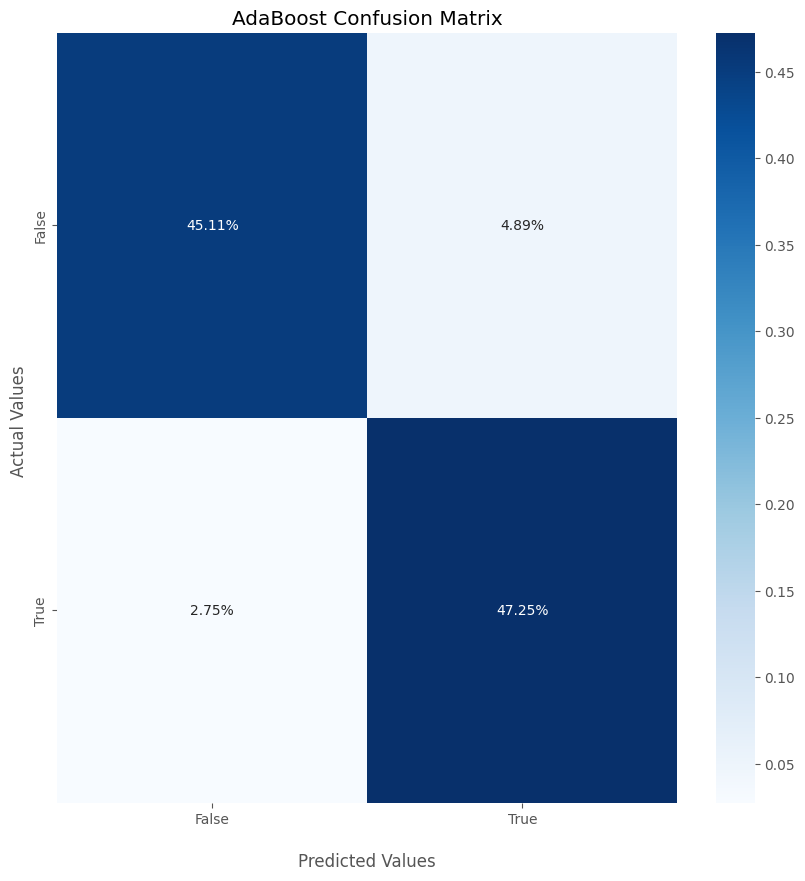

In [12]:
cm = get_confusion_matrix(ada_search, X_test, y_test)

labels = ['Non-Fraud', 'Possibly-Fraud']

plt.figure(figsize = (10,10))

ax = sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('AdaBoost Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()